In [ ]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# ดึงข้อมูลหุ้น PTT
stock_symbol = "PTT.BK"  # สำหรับตลาดหลักทรัพย์ไทย (SET)
df = yf.download(stock_symbol, start="2023-01-01", end="2023-12-31")
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,PTT.BK,PTT.BK,PTT.BK,PTT.BK,PTT.BK
Date,,,,,
2023-01-03,28.252239,28.899237,28.252239,28.467905,46133500
2023-01-04,27.605240,28.036572,27.605240,28.036572,54885800
2023-01-05,27.820908,27.820908,27.605242,27.605242,32895800
2023-01-06,28.036572,28.252237,27.820906,27.820906,53655400
2023-01-09,28.467905,28.683571,28.252239,28.252239,48532500


In [ ]:
excel_filename = "PTT_Stock_2023.xlsx"
df.to_excel(excel_filename)

In [ ]:
df1=pd.read_excel("/content/PTT_Stock_2023.xlsx")
df1.head()


,Price,Close,High,Low,Open,Volume
0,Ticker,PTT.BK,PTT.BK,PTT.BK,PTT.BK,PTT.BK
1,Date,NaN,NaN,NaN,NaN,NaN
2,2023-01-03 00:00:00,28.252239,28.899237,28.252239,28.467905,46133500
3,2023-01-04 00:00:00,27.60524,28.036572,27.60524,28.036572,54885800
4,2023-01-05 00:00:00,27.820908,27.820908,27.605242,27.605242,32895800


In [ ]:
df1 = df1.drop(df1.index[[0, 1]])
df1.head()

,Price,Close,High,Low,Open,Volume
2,2023-01-03 00:00:00,28.252239,28.899237,28.252239,28.467905,46133500
3,2023-01-04 00:00:00,27.60524,28.036572,27.60524,28.036572,54885800
4,2023-01-05 00:00:00,27.820908,27.820908,27.605242,27.605242,32895800
5,2023-01-06 00:00:00,28.036572,28.252237,27.820906,27.820906,53655400
6,2023-01-09 00:00:00,28.467905,28.683571,28.252239,28.252239,48532500


In [ ]:
# เช็คข้อมูลที่หายไป
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Price   Ticker
Close   PTT.BK    0
High    PTT.BK    0
Low     PTT.BK    0
Open    PTT.BK    0
Volume  PTT.BK    0
dtype: int64


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 2 to 244
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   243 non-null    object
 1   Close   243 non-null    object
 2   High    243 non-null    object
 3   Low     243 non-null    object
 4   Open    243 non-null    object
 5   Volume  243 non-null    object
dtypes: object(6)
memory usage: 11.5+ KB


In [ ]:
df1.describe()

<ipython-input-40-784441b173b6>:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  df1.describe()


,Price,Close,High,Low,Open,Volume
count,243,243.000000,243.000000,243.000000,243.000000,243
unique,243,53.000000,116.000000,116.000000,139.000000,243
top,2023-01-03 00:00:00,27.781631,28.002121,27.561142,27.781631,46133500
freq,1,24.000000,15.000000,11.000000,10.000000,1


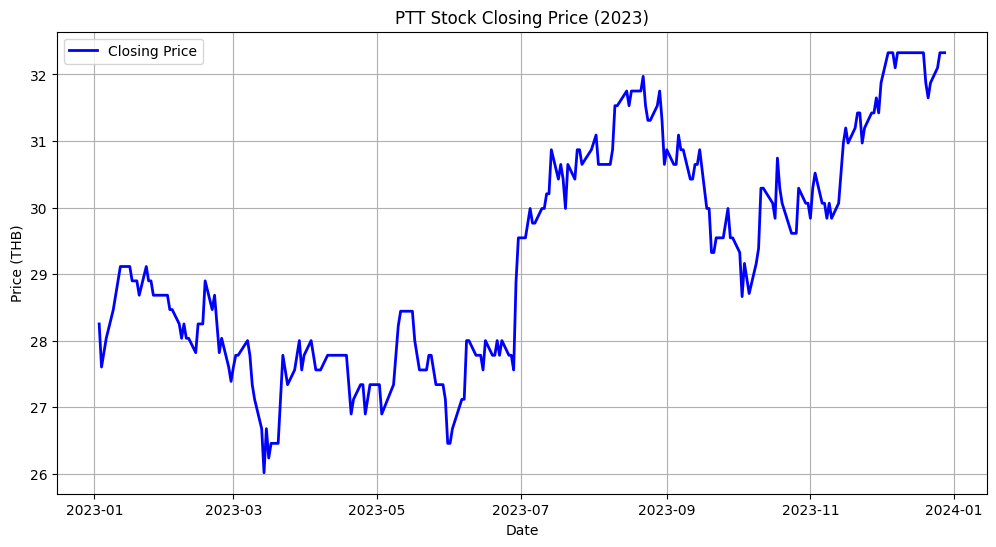

In [ ]:
# สร้างกราฟราคาปิดของหุ้น PTT
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Closing Price", linewidth=2, color='blue')

plt.title("PTT Stock Closing Price (2023)")
plt.xlabel("Date")
plt.ylabel("Price (THB)")
plt.legend()
plt.grid()

# แสดงกราฟ
plt.show()


In [ ]:



data = df[["Close"]].values

# สเกลข้อมูลให้อยู่ในช่วง 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# ฟังก์ชันสร้างชุดข้อมูลแบบ Time Series
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# ตั้งค่าช่วงเวลา 60 วันย้อนหลังเพื่อพยากรณ์วันถัดไป
time_step = 60
X, Y = create_dataset(scaled_data, time_step)

# แบ่ง Train-Test (80-20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# แปลงให้เป็นรูปแบบที่เหมาะสมกับ LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# สร้างโมเดล LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# คอมไพล์โมเดล
model.compile(optimizer="adam", loss="mean_squared_error")

# เทรนโมเดล
model.fit(X_train, Y_train, batch_size=16, epochs=50, verbose=1)

# ทำการพยากรณ์ปี 2024
future_days = 365  # จำนวนวันที่ต้องการทำนาย
future_predictions = []

# ใช้ข้อมูล 60 วันสุดท้ายเป็นจุดเริ่มต้น
last_60_days = scaled_data[-time_step:].reshape(1, time_step, 1)

for _ in range(future_days):
    pred = model.predict(last_60_days, verbose=0)
    pred = pred.reshape(1, 1, 1)  # แปลงให้มีขนาด 3 มิติ
    future_predictions.append(pred[0, 0])
    last_60_days = np.append(last_60_days[:, 1:, :], pred, axis=1)

# แปลงค่ากลับเป็นราคาหุ้นจริง
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# แปลง last_date ให้เป็น datetime
last_date = pd.to_datetime(df.index[-1])

# สร้างช่วงวันที่สำหรับปี 2024
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.2453
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0300
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0196
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0143
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0127
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0114
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0106
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0116
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0105
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0110
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0083
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0093
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0100
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0096
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0109
Epoch 16/50
10/

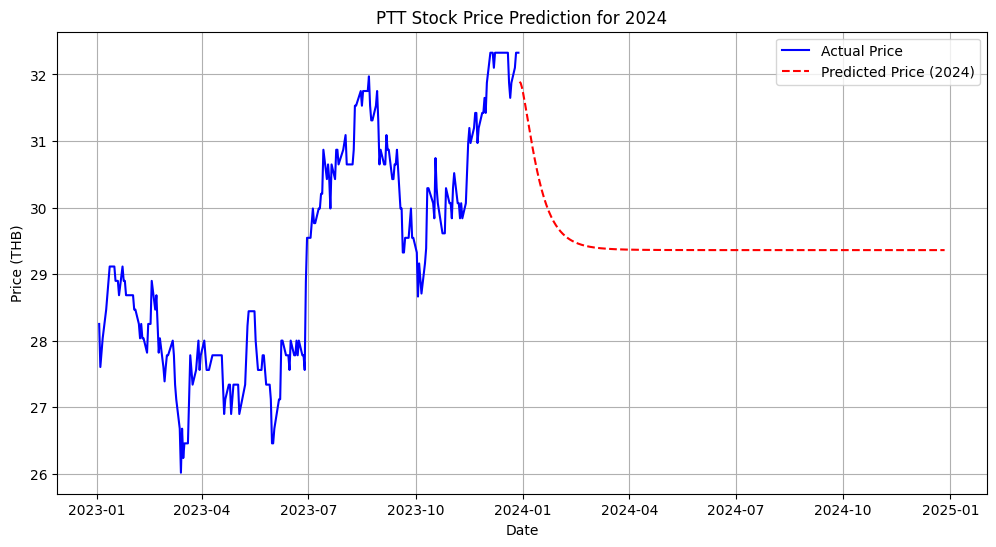

In [ ]:
# ตรวจสอบและแปลง df.index และ future_dates เป็น datetime
df.index = pd.to_datetime(df.index, errors="coerce")
future_dates = pd.to_datetime(future_dates, errors="coerce")

# วาดกราฟทำนายราคาหุ้นปี 2024
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Actual Price", color="blue")
plt.plot(future_dates, future_predictions, label="Predicted Price (2024)", color="red", linestyle="dashed")
plt.title("PTT Stock Price Prediction for 2024")
plt.xlabel("Date")
plt.ylabel("Price (THB)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# สร้าง DataFrame สำหรับผลลัพธ์การพยากรณ์
predicted_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Price": future_predictions.flatten()
})


In [ ]:
predicted_df.head(10)

,Date,Predicted Price
0,2023-12-29,31.889690
1,2023-12-30,31.868898
2,2023-12-31,31.805992
3,2024-01-01,31.722393
4,2024-01-02,31.628002
5,2024-01-03,31.527800
6,2024-01-04,31.424612
7,2024-01-05,31.320234
8,2024-01-06,31.215982
9,2024-01-07,31.112873


In [ ]:
from sklearn.metrics import accuracy_score

# ตัวอย่างข้อมูลจริง (y_true) และค่าที่โมเดลทำนายได้ (y_pred)
y_true = [1, 0, 1, 1, 0, 1, 0, 0, 1, 1]  # ค่าที่ถูกต้องจริง ๆ
y_pred = [1, 0, 1, 0, 0, 1, 0, 1, 1, 1]  # ค่าที่โมเดลพยากรณ์

# คำนวณค่าความแม่นยำ
model_scores = accuracy_score(y_true, y_pred)

# แสดงผลค่าความแม่นยำของโมเดล
print(f'Accuracy of the model: {model_scores:.2f}')



Accuracy of the model: 0.80


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ตัวอย่างข้อมูลราคาหุ้น PTT จริง (y_true) และค่าที่โมเดลทำนาย (y_pred)
y_true = [40.50, 42.10, 43.00, 41.30, 44.20]  # ราคาหุ้นจริง (ราคาปิด)
y_pred = [40.00, 42.50, 43.20, 41.00, 44.50]  # ค่าที่โมเดลทำนาย

# คำนวณ MSE, RMSE, MAE, R²
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# แสดงผลลัพธ์
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-squared (R² Score): {r2:.4f}')


Mean Squared Error (MSE): 0.1260
Root Mean Squared Error (RMSE): 0.3550
Mean Absolute Error (MAE): 0.3400
R-squared (R² Score): 0.9245
